## Bare pretrained Resnet backbone evaluation

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet_dir = "../pretrained_backbone/ckpt_resnet18_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

## Datasets

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [4]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [6]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)
    
    def forward(self, X):
        return self.model(X)
        
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## No fine-tuning: Evaluation directly on ODIR test set

In [7]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    for X, _ in tqdm(loader):
        output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
        preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [8]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.33it/s]

              precision    recall  f1-score   support

           D       0.74      0.36      0.48       140
           G       0.52      0.55      0.53        49
           A       0.38      0.77      0.51        22

   micro avg       0.57      0.45      0.50       211
   macro avg       0.54      0.56      0.51       211
weighted avg       0.65      0.45      0.50       211
 samples avg       0.59      0.43      0.38       211



### Offsite

![](resnet_no_tuning.png)

In [9]:
eval_model(model, onsite_test, "resnet_submission_notune.csv")

100%|██████████| 8/8 [00:01<00:00,  7.06it/s]


## Frozen backbone, fine-tuning classifier only

In [10]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.fc.parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [11]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            
        train_loss = train_loss / train_size

        model.eval()
        preds = []
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                preds.extend((output > 0.5).cpu().long().numpy())
        
        preds = np.stack(preds)

        val_loss = val_loss / eval_size
        val_accuracy = accuracy_score(eval_data.data[label_names].to_numpy(), preds)
        val_f1 = f1_score(eval_data.data[label_names].to_numpy(), preds, average="macro")

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (macro): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()
    
    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

Using Adam with default parameters, no weight decay + a bit of LR scheduling

Validation: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch: 0 - Train Loss: 1.195073 - Val Loss: 0.827466 - Val Accuracy: 0.360000 - Val F1 (macro): 0.522230
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch: 1 - Train Loss: 0.597543 - Val Loss: 0.575753 - Val Accuracy: 0.540000 - Val F1 (macro): 0.558076
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch: 2 - Train Loss: 0.492942 - Val Loss: 0.518461 - Val Accuracy: 0.555000 - Val F1 (macro): 0.536881
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch: 3 - Train Loss: 0.482121 - Val Loss: 0.521800 - Val Accuracy: 0.575000 - Val F1 (macro): 0.528800


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


Epoch: 4 - Train Loss: 0.467105 - Val Loss: 0.512990 - Val Accuracy: 0.580000 - Val F1 (macro): 0.499209
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch: 5 - Train Loss: 0.461675 - Val Loss: 0.509158 - Val Accuracy: 0.575000 - Val F1 (macro): 0.510541
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch: 6 - Train Loss: 0.465740 - Val Loss: 0.492510 - Val Accuracy: 0.585000 - Val F1 (macro): 0.585433
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch: 7 - Train Loss: 0.455167 - Val Loss: 0.502342 - Val Accuracy: 0.580000 - Val F1 (macro): 0.518152


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch: 8 - Train Loss: 0.448191 - Val Loss: 0.509764 - Val Accuracy: 0.585000 - Val F1 (macro): 0.506336


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch: 9 - Train Loss: 0.445236 - Val Loss: 0.514858 - Val Accuracy: 0.565000 - Val F1 (macro): 0.451174


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch: 10 - Train Loss: 0.450655 - Val Loss: 0.492795 - Val Accuracy: 0.560000 - Val F1 (macro): 0.522290


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch: 11 - Train Loss: 0.446725 - Val Loss: 0.511175 - Val Accuracy: 0.595000 - Val F1 (macro): 0.496685


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch: 12 - Train Loss: 0.434698 - Val Loss: 0.487931 - Val Accuracy: 0.585000 - Val F1 (macro): 0.524363
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch: 13 - Train Loss: 0.432437 - Val Loss: 0.491618 - Val Accuracy: 0.595000 - Val F1 (macro): 0.531787


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.24it/s]


Epoch: 14 - Train Loss: 0.438692 - Val Loss: 0.504987 - Val Accuracy: 0.595000 - Val F1 (macro): 0.503164


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch: 15 - Train Loss: 0.439003 - Val Loss: 0.473884 - Val Accuracy: 0.580000 - Val F1 (macro): 0.571594
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


Epoch: 16 - Train Loss: 0.429027 - Val Loss: 0.488511 - Val Accuracy: 0.595000 - Val F1 (macro): 0.527024


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch: 17 - Train Loss: 0.427884 - Val Loss: 0.495794 - Val Accuracy: 0.580000 - Val F1 (macro): 0.497965


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch: 18 - Train Loss: 0.427586 - Val Loss: 0.481340 - Val Accuracy: 0.590000 - Val F1 (macro): 0.528979


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch: 19 - Train Loss: 0.431966 - Val Loss: 0.483941 - Val Accuracy: 0.590000 - Val F1 (macro): 0.558341


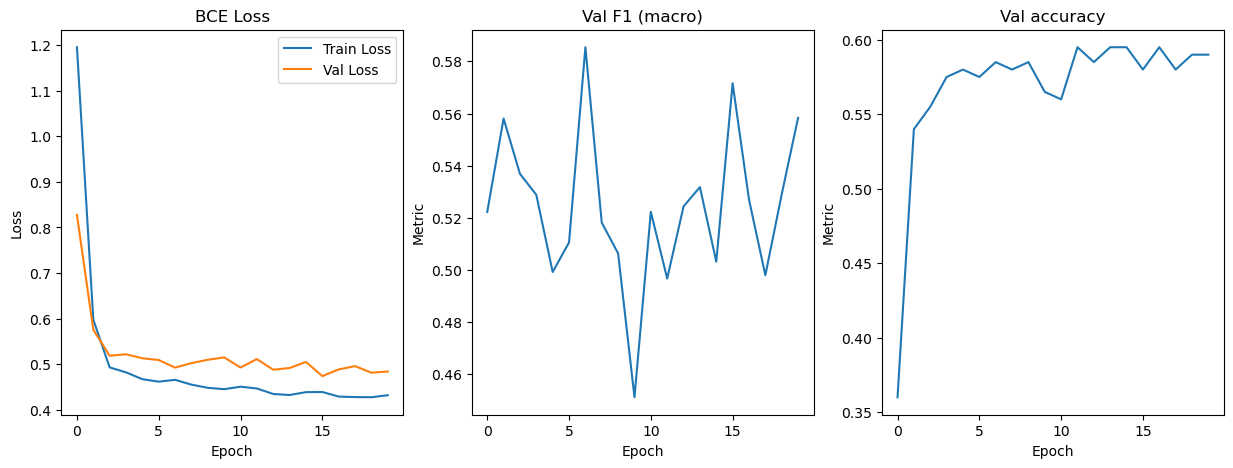

In [12]:
optimizer = torch.optim.Adam(model.model.fc.parameters(), lr = 1e-3)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="resnet_tuned_classifer.pt")

### Offsite test

In [13]:
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "resnet_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


              precision    recall  f1-score   support

           D       0.82      0.86      0.84       140
           G       0.76      0.27      0.39        49
           A       0.56      0.41      0.47        22

   micro avg       0.79      0.67      0.73       211
   macro avg       0.72      0.51      0.57       211
weighted avg       0.78      0.67      0.70       211
 samples avg       0.79      0.69      0.69       211



### Onsite test
![](resnet_classifier_tuning.png)

In [14]:
eval_model(model, onsite_test, "resnet_submission_classifier_tune.csv")

100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


## Full fine-tuning

We previously tuned the classifer, and we further now tune everything, using the best model from previous stage

Using AdamW with default weight decay of 0.01, 5 epochs, overfits.

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


Epoch: 0 - Train Loss: 0.369818 - Val Loss: 0.382124 - Val Accuracy: 0.700000 - Val F1 (macro): 0.682486
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch: 1 - Train Loss: 0.209585 - Val Loss: 0.371178 - Val Accuracy: 0.710000 - Val F1 (macro): 0.733506
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch: 2 - Train Loss: 0.109339 - Val Loss: 0.380015 - Val Accuracy: 0.735000 - Val F1 (macro): 0.758467


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch: 3 - Train Loss: 0.056713 - Val Loss: 0.422848 - Val Accuracy: 0.720000 - Val F1 (macro): 0.738880


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Epoch: 4 - Train Loss: 0.037993 - Val Loss: 0.424161 - Val Accuracy: 0.735000 - Val F1 (macro): 0.744497


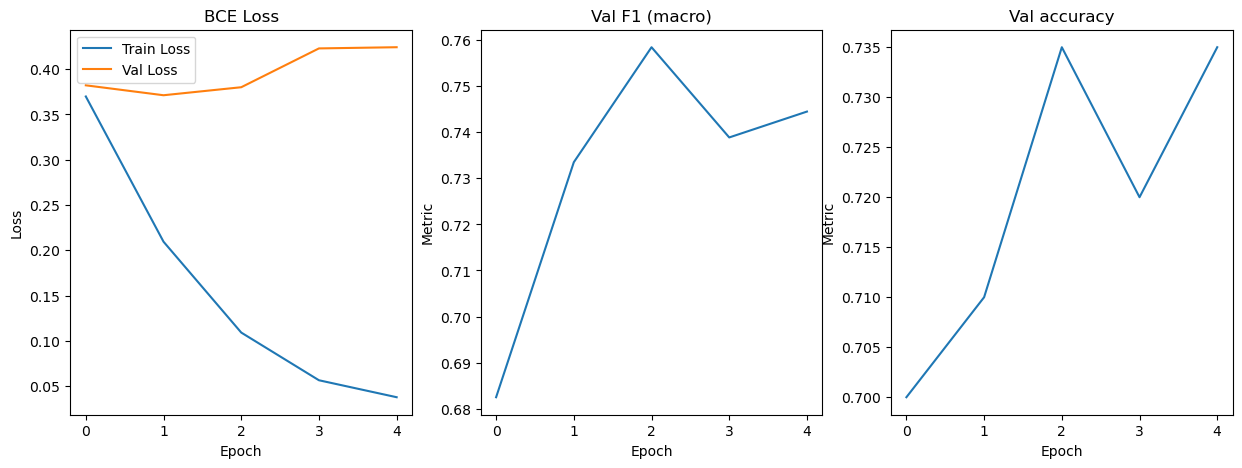

In [15]:
'''
backbone_params = []
fc_params = []
for name, param in model.named_parameters():
    if "fc" not in name:
        backbone_params.append(param)
    else:
        fc_params.append(param)
'''
BATCH = 32
for layer in model.parameters():
    layer.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) #default weight decay 0.01
criterion = nn.BCEWithLogitsLoss()
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=25)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=5, stepLR = scheduler, checkpoint_name="resnet.pt")

### Offsite

In [16]:
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "resnet.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  7.87it/s]

              precision    recall  f1-score   support

           D       0.88      0.89      0.89       140
           G       0.89      0.67      0.77        49
           A       0.57      0.59      0.58        22

   micro avg       0.85      0.81      0.83       211
   macro avg       0.78      0.72      0.74       211
weighted avg       0.85      0.81      0.83       211
 samples avg       0.85      0.82      0.83       211



### Onsite test
![](resnet_classifier_full.png)

In [17]:
eval_model(model, onsite_test, "resnet_submission_full.csv")

100%|██████████| 8/8 [00:01<00:00,  7.56it/s]
